# Part 0: Import 套件

In [1]:
#下載資料套件
import urllib3
from bs4 import BeautifulSoup

#資料處理套件
import pandas as pd
from datetime import datetime, date
import numpy as np

#畫圖套件
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Part 1: 下載期交所 臺指選擇權 每日交易行情

#### 股海小英雄youtube影片：
- [【Python 爬蟲】台指選擇權每日交易行情免費下載｜一眼看出各個履約價的走勢](https://youtu.be/jgN-mFR-12w)
- [【Python 爬蟲】台指選即時成交行情免費下載｜這次盤中大贏家就是你！](https://youtu.be/UJso4OS5w7Q)

#### **注意:查詢區間不可超過30日**

## 1.1: 下載臺指選擇權每日交易行情函式

In [2]:
def get_option(commodity_id, queryStartDate, queryEndDate):

    # 用urllib3下載選擇權每日交易行情資料
    http = urllib3.PoolManager()
    url = "https://www.taifex.com.tw/cht/3/dlOptDataDown"
    res = http.request(
         'POST',
          url,
          fields={
             'down_type': 1,
             'commodity_id': commodity_id,
             'queryStartDate': queryStartDate,
             'queryEndDate': queryEndDate
          }
     )
    html_doc = res.data
    
    # 用BeautifulSoup解析資料
    soup = BeautifulSoup(html_doc, 'html.parser')
    soup_str = str(soup)
    lines = soup_str.split('\r\n')

    # 新增空的dataframe,定義欄位名稱
    df = pd.DataFrame(columns = lines[0].split(','))

    # 把選擇權資料一行一行寫入dataframe內
    for i in range(1, len(lines) - 1):
        list_ = lines[i].split(',')[:-1]
        df_length = len(df)
        df.loc[df_length] = list_
        
    # 資料轉型
    for col in [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]), int(day[1]), int(day[2]))  
            # 把"履約價"改成沒有小數點的字串
            elif col == 3:
                price = df.iloc[row,3].split('.')
                df.iloc[row,3] = str(price[0])
            # 把字串(string)換成浮點數(float): "履約價", "開盤價", "最高價", "最低價", "收盤價", "成交量", "結算價", "未沖銷契約數", "最後最佳買價", "最後最佳賣價", "歷史最高價", "歷史最低價" 
            elif col != 0 and df.iloc[row, col] != '-':
                df.iloc[row, col] = float(df.iloc[row,col])

    return df

## 1.2: 下載臺指選擇權 2021/11/03 - 2021/11/10 的行情資料

In [16]:
df = get_option(commodity_id = 'TXO', 
                queryStartDate = '2021/11/3', 
                queryEndDate = '2021/11/10')
df

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段
0,2021-11-03 00:00:00,TXO,202111W1,15200,買權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般
1,2021-11-03 00:00:00,TXO,202111W1,15200,買權,-,-,-,-,0.0,-,-,-,-,-,-,,盤後
2,2021-11-03 00:00:00,TXO,202111W1,15200,賣權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般
3,2021-11-03 00:00:00,TXO,202111W1,15200,賣權,-,-,-,-,0.0,-,-,-,-,-,-,,盤後
4,2021-11-03 00:00:00,TXO,202111W1,15300,買權,-,-,-,-,0.0,0.0,1.0,-,-,-,-,,一般
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2021-11-10 00:00:00,TXO,202206,21000,買權,37.0,37.0,37.0,37.0,1.0,-,-,36.5,46.5,78.0,27.0,,盤後
8204,2021-11-10 00:00:00,TXO,202206,21000,賣權,-,-,-,-,0.0,3760.0,0.0,-,-,-,-,,一般
8205,2021-11-10 00:00:00,TXO,202206,21000,賣權,-,-,-,-,0.0,-,-,-,-,-,-,,盤後
8206,2021-11-10 00:00:00,TXO,202206,21200,買權,29.5,30.5,29.5,30.5,4.0,30.5,4.0,29.0,40.0,30.5,29.5,,一般


## 1.3: 取得臺指選擇權 202111W2/買權/一般交易時間 資料

In [4]:
call_df = df.loc[(df['到期月份(週別)'] == '202111W2') & \
                (df['買賣權'] == '買權') & \
                (df['交易時段'] == '一般')]

call_df

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段
192,2021-11-03 00:00:00,TXO,202111W2,15300,買權,-,-,-,-,0.0,1800.0,0.0,-,-,-,-,,一般
194,2021-11-03 00:00:00,TXO,202111W2,15400,買權,-,-,-,-,0.0,1700.0,0.0,-,-,-,-,,一般
196,2021-11-03 00:00:00,TXO,202111W2,15500,買權,-,-,-,-,0.0,1600.0,0.0,-,-,-,-,,一般
198,2021-11-03 00:00:00,TXO,202111W2,15600,買權,-,-,-,-,0.0,1500.0,0.0,-,-,-,-,,一般
200,2021-11-03 00:00:00,TXO,202111W2,15700,買權,-,-,-,-,0.0,1400.0,0.0,-,-,-,-,,一般
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,2021-11-10 00:00:00,TXO,202111W2,18900,買權,-,-,-,-,0.0,0.0,1.0,-,-,-,-,,一般
7004,2021-11-10 00:00:00,TXO,202111W2,19000,買權,0.1,0.1,0.1,0.1,136.0,0.0,0.0,-,0.5,0.1,0.1,,一般
7008,2021-11-10 00:00:00,TXO,202111W2,19100,買權,-,-,-,-,0.0,0.0,2.0,-,-,-,-,,一般
7012,2021-11-10 00:00:00,TXO,202111W2,19200,買權,-,-,-,-,0.0,0.0,11.0,-,-,-,-,,一般


## 1.4: 買權資料整理

In [5]:
# 取得 dataframe index
index = call_df['履約價'].unique()
idx = np.sort(index)
idx

array(['15300', '15400', '15500', '15600', '15700', '15800', '15900',
       '16000', '16100', '16200', '16300', '16400', '16500', '16600',
       '16650', '16700', '16750', '16800', '16850', '16900', '16950',
       '17000', '17050', '17100', '17150', '17200', '17250', '17300',
       '17350', '17400', '17450', '17500', '17550', '17600', '17650',
       '17700', '17750', '17800', '17850', '17900', '17950', '18000',
       '18050', '18100', '18200', '18300', '18400', '18500', '18600',
       '18700', '18800', '18900', '19000', '19100', '19200', '19300'],
      dtype=object)

In [6]:
# 取得 dataframe 欄位名稱
dates = call_df['交易日期'].unique()
dates

array([datetime.datetime(2021, 11, 3, 0, 0),
       datetime.datetime(2021, 11, 4, 0, 0),
       datetime.datetime(2021, 11, 5, 0, 0),
       datetime.datetime(2021, 11, 8, 0, 0),
       datetime.datetime(2021, 11, 9, 0, 0),
       datetime.datetime(2021, 11, 10, 0, 0)], dtype=object)

In [7]:
# 建立 dataframe 包含 index 與欄位名稱
call_t_df = pd.DataFrame(index = idx, columns = list(dates))
call_t_df

,2021-11-03,2021-11-04,2021-11-05,2021-11-08,2021-11-09,2021-11-10
15300,NaN,NaN,NaN,NaN,NaN,NaN
15400,NaN,NaN,NaN,NaN,NaN,NaN
15500,NaN,NaN,NaN,NaN,NaN,NaN
15600,NaN,NaN,NaN,NaN,NaN,NaN
15700,NaN,NaN,NaN,NaN,NaN,NaN
15800,NaN,NaN,NaN,NaN,NaN,NaN
15900,NaN,NaN,NaN,NaN,NaN,NaN
16000,NaN,NaN,NaN,NaN,NaN,NaN
16100,NaN,NaN,NaN,NaN,NaN,NaN
16200,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 取出各日期的未沖銷契約數 依序放入 dataframe 中
for col in call_t_df.columns:
    call_t_df[col] = call_df.loc[call_df['交易日期'] == col].set_index('履約價')['未沖銷契約數']
    
#空值填入 0
call_t_df = call_t_df.fillna(0)
call_t_df

,2021-11-03,2021-11-04,2021-11-05,2021-11-08,2021-11-09,2021-11-10
15300,0.0,0.0,0.0,0.0,0.0,0.0
15400,0.0,0.0,0.0,0.0,0.0,0.0
15500,0.0,0.0,0.0,0.0,0.0,0.0
15600,0.0,0.0,0.0,0.0,0.0,0.0
15700,0.0,0.0,0.0,0.0,0.0,0.0
15800,0.0,0.0,0.0,1.0,1.0,1.0
15900,0.0,0.0,0.0,0.0,0.0,0.0
16000,0.0,0.0,0.0,0.0,0.0,0.0
16100,0.0,0.0,0.0,0.0,0.0,0.0
16200,0.0,0.0,0.0,0.0,0.0,0.0


## 1.5: 取得臺指選擇權 202111W2/賣權/一般交易時間 資料

In [9]:
put_df = df.loc[(df['到期月份(週別)'] == '202111W2') & \
                (df['買賣權'] == '賣權') & \
                (df['交易時段'] == '一般')]

put_df

,交易日期,契約,到期月份(週別),履約價,買賣權,開盤價,最高價,最低價,收盤價,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段
193,2021-11-03 00:00:00,TXO,202111W2,15300,賣權,1.0,1.3,0.9,0.9,972.0,0.9,881.0,0.8,0.9,1.3,0.9,,一般
195,2021-11-03 00:00:00,TXO,202111W2,15400,賣權,0.9,0.9,0.9,0.9,19.0,0.9,19.0,0.9,1.0,0.9,0.9,,一般
197,2021-11-03 00:00:00,TXO,202111W2,15500,賣權,1.2,2.0,1.2,2.0,2.0,1.1,1.0,0.6,1.5,2.0,1.2,,一般
199,2021-11-03 00:00:00,TXO,202111W2,15600,賣權,1.6,1.6,1.3,1.3,4.0,1.3,2.0,1.0,2.4,1.6,1.3,,一般
201,2021-11-03 00:00:00,TXO,202111W2,15700,賣權,1.7,1.9,1.6,1.9,16.0,1.5,16.0,1.0,1.6,1.9,1.6,,一般
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,2021-11-10 00:00:00,TXO,202111W2,18900,賣權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般
7006,2021-11-10 00:00:00,TXO,202111W2,19000,賣權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般
7010,2021-11-10 00:00:00,TXO,202111W2,19100,賣權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般
7014,2021-11-10 00:00:00,TXO,202111W2,19200,賣權,-,-,-,-,0.0,0.0,0.0,-,-,-,-,,一般


## 1.6: 賣權資料整理

In [10]:
# 取得 dataframe index
index = put_df['履約價'].unique()
idx = np.sort(index)
idx

array(['15300', '15400', '15500', '15600', '15700', '15800', '15900',
       '16000', '16100', '16200', '16300', '16400', '16500', '16600',
       '16650', '16700', '16750', '16800', '16850', '16900', '16950',
       '17000', '17050', '17100', '17150', '17200', '17250', '17300',
       '17350', '17400', '17450', '17500', '17550', '17600', '17650',
       '17700', '17750', '17800', '17850', '17900', '17950', '18000',
       '18050', '18100', '18200', '18300', '18400', '18500', '18600',
       '18700', '18800', '18900', '19000', '19100', '19200', '19300'],
      dtype=object)

In [11]:
# 取得 dataframe 欄位名稱
dates = put_df['交易日期'].unique()
dates

array([datetime.datetime(2021, 11, 3, 0, 0),
       datetime.datetime(2021, 11, 4, 0, 0),
       datetime.datetime(2021, 11, 5, 0, 0),
       datetime.datetime(2021, 11, 8, 0, 0),
       datetime.datetime(2021, 11, 9, 0, 0),
       datetime.datetime(2021, 11, 10, 0, 0)], dtype=object)

In [12]:
# 建立 dataframe 包含 index 與欄位名稱
put_t_df = pd.DataFrame(index = idx, columns = list(dates))
put_t_df

,2021-11-03,2021-11-04,2021-11-05,2021-11-08,2021-11-09,2021-11-10
15300,NaN,NaN,NaN,NaN,NaN,NaN
15400,NaN,NaN,NaN,NaN,NaN,NaN
15500,NaN,NaN,NaN,NaN,NaN,NaN
15600,NaN,NaN,NaN,NaN,NaN,NaN
15700,NaN,NaN,NaN,NaN,NaN,NaN
15800,NaN,NaN,NaN,NaN,NaN,NaN
15900,NaN,NaN,NaN,NaN,NaN,NaN
16000,NaN,NaN,NaN,NaN,NaN,NaN
16100,NaN,NaN,NaN,NaN,NaN,NaN
16200,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 取出各日期的未沖銷契約數 依序放入 dataframe 中
for col in put_t_df.columns:
    put_t_df[col] = put_df.loc[put_df['交易日期'] == col].set_index('履約價')['未沖銷契約數']

#空值填入 0
put_t_df = put_t_df.fillna(0)
put_t_df

,2021-11-03,2021-11-04,2021-11-05,2021-11-08,2021-11-09,2021-11-10
15300,881.0,1699.0,1718.0,1718.0,1718.0,1718.0
15400,19.0,46.0,53.0,53.0,53.0,53.0
15500,1.0,101.0,201.0,201.0,201.0,201.0
15600,2.0,24.0,114.0,115.0,135.0,135.0
15700,16.0,58.0,74.0,74.0,74.0,74.0
15800,121.0,205.0,225.0,225.0,225.0,225.0
15900,536.0,593.0,648.0,649.0,649.0,649.0
16000,558.0,728.0,730.0,706.0,729.0,729.0
16100,573.0,773.0,1013.0,762.0,763.0,754.0
16200,728.0,761.0,875.0,859.0,807.0,806.0


# Part 2: 畫臺指選擇權未平倉壓力支撐圖(含差值)
#### 股海小英雄youtube影片：
- [【選擇權分析】畫選擇權支撐壓力圖｜判斷選擇權買點](https://youtu.be/JLcopeuYCnw)

## 2.1: 畫單日未平倉壓力支撐圖(含差值)

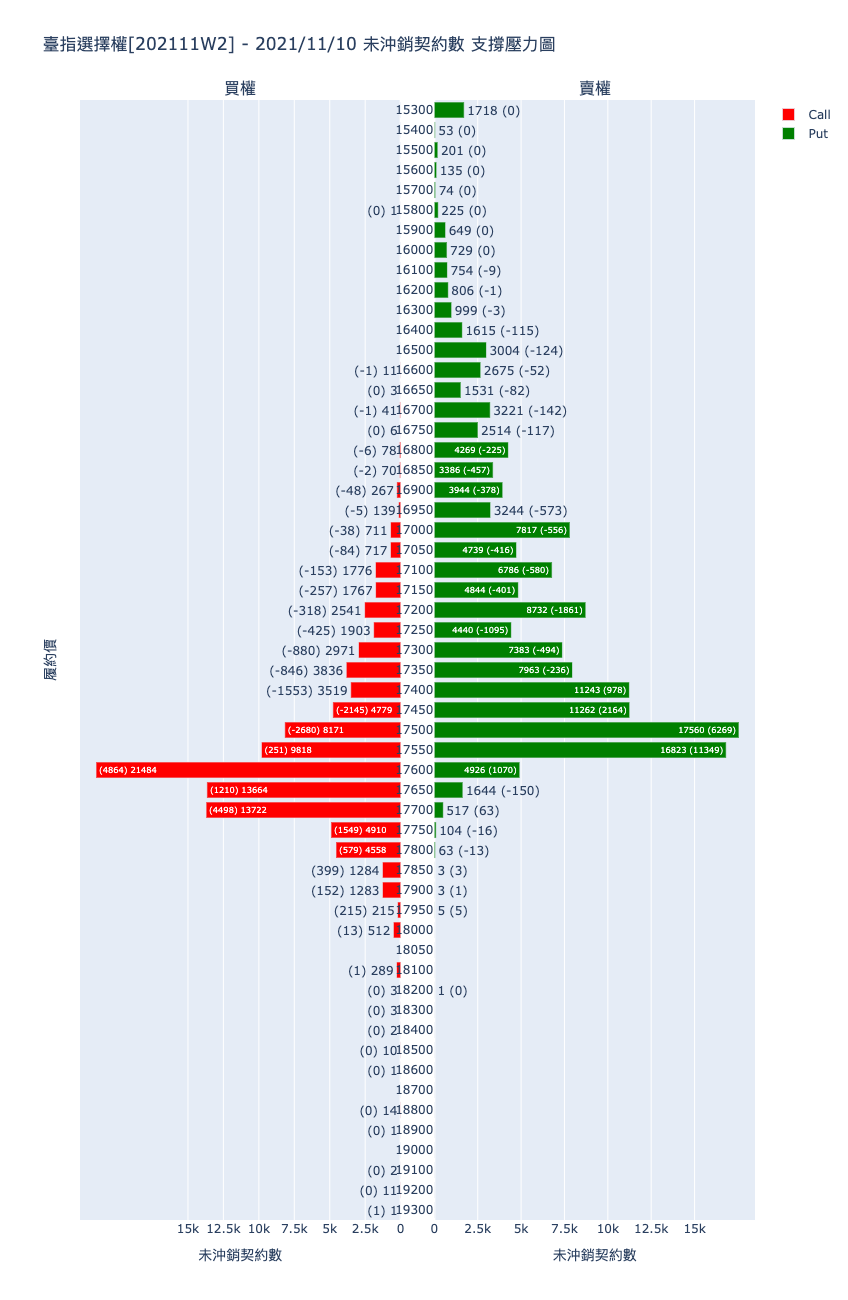

In [20]:
# 設定左右子圖
fig = make_subplots(
    rows=1, 
    cols=2, 
    horizontal_spacing = 0.05, 
    subplot_titles = ("買權", "賣權")
)

# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-10'],
                     orientation = 'h',
                     name = 'Call',
                     text = ("(" + (call_t_df['2021-11-10'] - call_t_df['2021-11-9']).astype('int').astype('str') + ") " + call_t_df['2021-11-10'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 1)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-10'],
                     orientation = 'h',
                     name = 'Put',
                     text = (put_t_df['2021-11-10'].astype('int').astype('str') + " (" + (put_t_df['2021-11-10'] - put_t_df['2021-11-9']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 2)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 1)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 2)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 title_text = "履約價",
                 row = 1, 
                 col = 1)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 2)



# 設定圖的標題跟長寬
fig.update_layout(title_text = "臺指選擇權[202111W2] - 2021/11/10 未沖銷契約數 支撐壓力圖", 
                  width = 1000, 
                  height = 1300)

fig.show()

## 2.2: 畫多日未平倉壓力支撐圖(含差值)

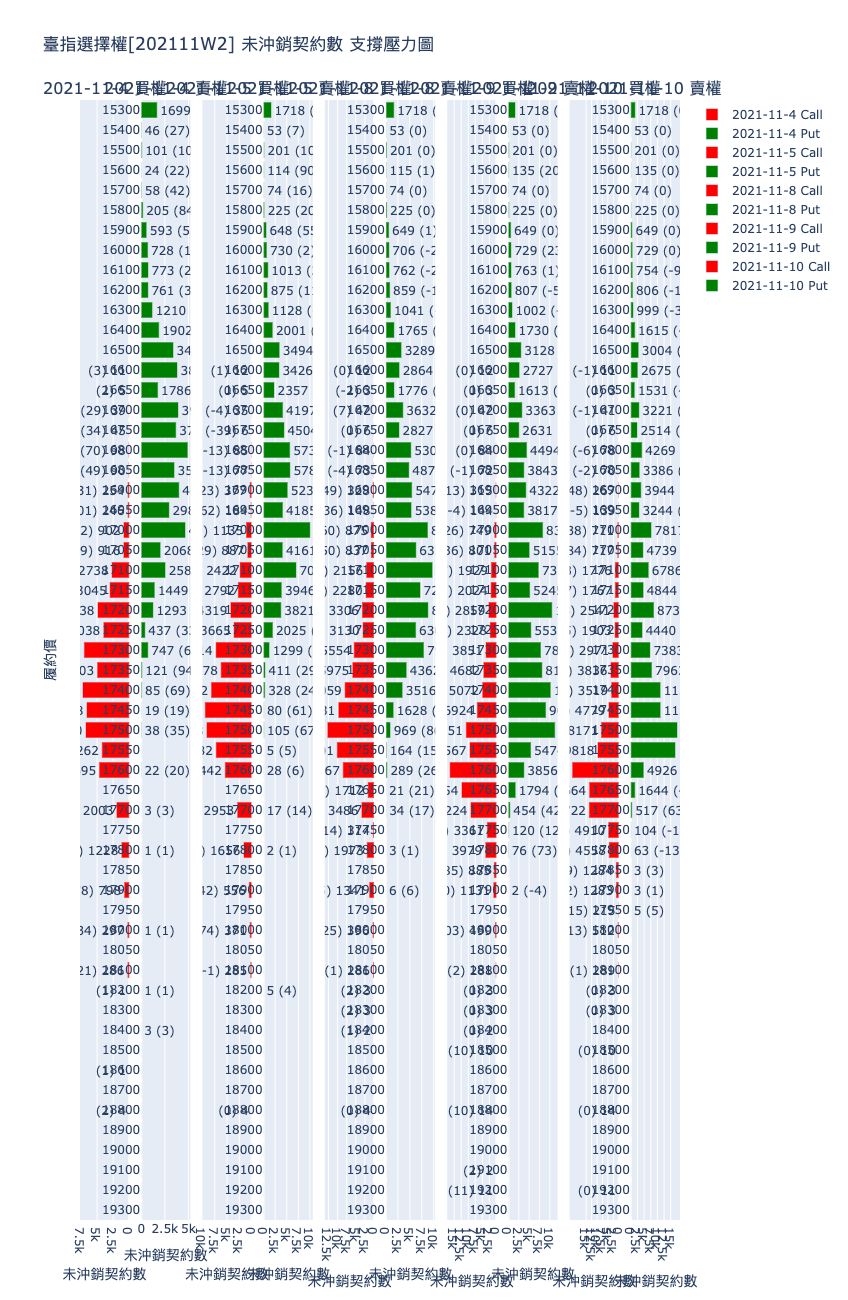

In [21]:
# 設定左右子圖
fig = make_subplots(
    rows = 1, 
    cols = 10, 
    horizontal_spacing = 0.02, 
    subplot_titles = ("2021-11-4 買權", "2021-11-4 賣權", "2021-11-5 買權", "2021-11-5 賣權", "2021-11-8 買權", "2021-11-8 賣權", "2021-11-9 買權", "2021-11-9 賣權", "2021-11-10 買權", "2021-11-10 賣權")
)

## 圖一
# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-4'],
                     orientation = 'h',
                     name = '2021-11-4 Call',
                     text = ("(" + (call_t_df['2021-11-4'] - call_t_df['2021-11-3']).astype('int').astype('str') + ") " + call_t_df['2021-11-4'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 1)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-4'],
                     orientation = 'h',
                     name = '2021-11-4 Put',
                     text = (put_t_df['2021-11-4'].astype('int').astype('str') + " (" + (put_t_df['2021-11-4'] - put_t_df['2021-11-3']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 2)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 1)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 2)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 title_text = "履約價",
                 row = 1, 
                 col = 1)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 2)


## 圖二
# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-5'],
                     orientation = 'h',
                     name = '2021-11-5 Call',
                     text = ("(" + (call_t_df['2021-11-5'] - call_t_df['2021-11-4']).astype('int').astype('str') + ") " + call_t_df['2021-11-5'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 3)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-5'],
                     orientation = 'h',
                     name = '2021-11-5 Put',
                     text = (put_t_df['2021-11-5'].astype('int').astype('str') + " (" + (put_t_df['2021-11-5'] - put_t_df['2021-11-4']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 4)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 3)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 4)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 3)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 4)


## 圖三
# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-8'],
                     orientation = 'h',
                     name = '2021-11-8 Call',
                     text = ("(" + (call_t_df['2021-11-8'] - call_t_df['2021-11-5']).astype('int').astype('str') + ") " + call_t_df['2021-11-8'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 5)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-8'],
                     orientation = 'h',
                     name = '2021-11-8 Put',
                     text = (put_t_df['2021-11-8'].astype('int').astype('str') + " (" + (put_t_df['2021-11-8'] - put_t_df['2021-11-5']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 6)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 5)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 6)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 5)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 6)

## 圖四
# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-9'],
                     orientation = 'h',
                     name = '2021-11-9 Call',
                     text = ("(" + (call_t_df['2021-11-9'] - call_t_df['2021-11-8']).astype('int').astype('str') + ") " + call_t_df['2021-11-9'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 7)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-9'],
                     orientation = 'h',
                     name = '2021-11-9 Put',
                     text = (put_t_df['2021-11-9'].astype('int').astype('str') + " (" + (put_t_df['2021-11-9'] - put_t_df['2021-11-8']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 8)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 7)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 8)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 7)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 8)

## 圖五
# 畫買權長條圖
fig.add_trace(go.Bar(y = call_t_df.index,
                     x = -call_t_df['2021-11-10'],
                     orientation = 'h',
                     name = '2021-11-10 Call',
                     text = ("(" + (call_t_df['2021-11-10'] - call_t_df['2021-11-9']).astype('int').astype('str') + ") " + call_t_df['2021-11-10'].astype('int').astype('str')),
                     marker = dict(color = 'red')), 
              row = 1, 
              col = 9)

# 畫賣權長條圖
fig.add_trace(go.Bar(y = put_t_df.index,
                     x = put_t_df['2021-11-10'],
                     orientation = 'h',
                     name = '2021-11-10 Put',
                     text = (put_t_df['2021-11-10'].astype('int').astype('str') + " (" + (put_t_df['2021-11-10'] - put_t_df['2021-11-9']).astype('int').astype('str') + ")"),
                     marker = dict(color = 'green')), 
              row = 1, 
              col = 10)


# 設定圖的x跟y軸標題
fig.update_xaxes(tickvals = [-15000, -12500, -10000, -7500, -5000, -2500, 0],
                 ticktext = ['15k', '12.5k', '10k', '7.5k', '5k', '2.5k', '0'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 9)

fig.update_xaxes(tickvals = [0, 2500, 5000, 7500, 10000, 12500, 15000],
                 ticktext = ['0', '2.5k', '5k', '7.5k', '10k', '12.5k', '15k'], 
                 title_text = "未沖銷契約數",
                 row = 1, 
                 col = 10)

fig.update_yaxes(autorange = "reversed", 
                 showticklabels = False, 
                 row = 1, 
                 col = 9)

fig.update_yaxes(autorange = "reversed", 
                 row = 1, 
                 col = 10)

# 設定圖的標題跟長寬
fig.update_layout(title_text = "臺指選擇權[202111W2] 未沖銷契約數 支撐壓力圖", 
                  width = 2400, 
                  height = 1300)

fig.show()